<h1 style="font-family: Georgia; font-size:3em;color:#2462C0; font-style:bold">
Regularization
</h1><br>

Regularization adds stability to learning algorithm by making it less sensitive to the training data and processes. Since we don't know and have no access to the true function that we can use to compare our estimated function with it, the best strategy would be to build a very complex model that fits the training data really well (overfitting) and regularize it so that it would have a good generalization (test) error. When using regularization, we try to reduce the generalization error and that may lead to increase the training error in the process which is okay because what we care about is how well the model generalizes. With regularization, we try to bring back the very complex model that suffers from overfitting to a good model by increasing bias and reducing variance. This builds on the assumption that complex model has large parameters and simple model has small parameters.

Below are some methods used for regularization:
1. **L2 Parameter Regularization (Ridge Regression)**: It's also known as **weight decay**. This method adds L2 norm penalty to the objective function to drive the weights towards the origin. Even though this method shrinks all weights by the same proportion towards zero; however, it will never make any weight to be zero.
2. **L1 Parameter Regularization (Lasso Regression)**: It can be seen as a feature selection method because; in contrast to ridge regression, some weights will be actually zero. It shrinks all weights by the same amount by adding L1 norm penalty to the objective function.
3. **Dropout**: Dropout can be seen as an approximation to bagging techniques. On each iteration, we randomly shut down some neurons on each layer and don't use those neurons in both forward propagation and back-propagation. This will force the neural network to spread out weights and focus on specific neurons because it will never know which neurons will show up on each iteration. Therefore, it can be seen as training different model on each iteration. Also, since we drop some neurons on each iteration, this will lead to smaller network which in turns means simpler network.
4. **Augmentation**: Add fake data by using the training examples and adding distortions to them such as rescaling and rotating the images in case of image recognition. The idea here is that it's always better to train the model on more data to achieve better performance. Note that augmented examples don't add much information to the model as much as independent examples do but still it's a valid alternative when collecting more data is not feasible.
5. **Early Stopping**: This method tries to optimize the cost function and regularize it so that it would have lower generalization error. The way it works is that on each iteration we record the validation error. If the validation error improves, we store a copy of the parameters and will continue until the optimization algorithm terminates. It's a good method if computational time and resources is an issue for us.

In this notebook, we'll cover L2 parameter regularization.

<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
L2 Parameter Regularization
</h2>

We normally don't regularize bias and regularize weights only. We can use hessian matrix and it's eigenvalues and eigenvectors to see the sensitivity of the weights to the weight decay. The weight $w_i$ will be rescaled using $\frac{\lambda_i}{\lambda_i + \alpha}$ where $\lambda_i$ (eigenvalue) measures the sensitivity of hessian matrix in that direction (eigenvector) and $\alpha$ is the regularized hyperparameter. Therefore,
- If $\lambda_i >> \alpha$, the cost function is very sensitive in that direction and the corresponding weight reduces the cost significantly $\Rightarrow$ don't decay (shrink) much.
- If $\lambda_i << \alpha$, the cost function is not sensitive in that direction and the corresponding weight doesn't reduce the cost significantly $\Rightarrow$ decay (shrink) away towards zero.

The objective function would then change from:
$$J = -\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small  y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} \tag{1}$$
To:
$$J_{regularized} = \small \underbrace{-\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} }_\text{cross-entropy cost} + \underbrace{\frac{1}{m} \frac{\lambda}{2} \sum\limits_{l=1}^L\sum\limits_{i=1}^{n^l}\sum\limits_{j=1}^{n^{l-1}} W_{j,i}^{[l]2} }_\text{L2 regularization cost} \tag{2}$$
Also, the new gradients and the update equation would be:
$$\nabla_w J_{regularized} = \nabla_w J + \frac{\lambda}{m}w\\{}$$
$$w = w - \alpha\nabla_w J - \alpha\frac{\lambda}{m}w\\{}$$
$$\Rightarrow w = w\underbrace{(1 - \alpha\frac{\lambda}{m})}_\text{weight decay} - \nabla J$$
Note that here $\alpha$ is the learning rate and $\lambda$ is the regularized hyperparameter. As $\lambda$ increases, the bias increases with the following extreme cases:
- $\lambda = 0$, no regularization.
- $\lambda \rightarrow \infty$, model becomes very simple where all weights are essentially zero. In the case of regression, we would end-up with the intercept only which is equal to the average of the target variable.

It sometimes maybe helpful to see how L2 parameter regularization wroks using normal equation. The normal quation is:
$$W = (X^TX + \lambda I)^{-1}X^TY\tag{3}$$
This means that:
- Adding $\lambda$ to the variance would decrease the weight since $w_i = \frac{cov_{x, y}}{\sigma^2_x}$.
- Even if $X^TX$ is not invertible, adding $\lambda$ to each column will make it full rank matrix $\Rightarrow$ invertible.

To illustrate how regularization helps us reduce generalization error, we'll use the same dataset we've used in the previous notebooks. The dataset has images for cats and non-cat. We'll try to build a neural network to classify if the image has cat or not. Each image is 64 x 64 pixels on RGB scale. Let's import the data and take a look at the shape as well as a sample of a cat image from the training set.

In [1]:
# Loading packages
import os

import h5py
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# local modules
os.chdir("../scripts/")
from coding_deep_neural_network_from_scratch import (initialize_parameters,
                                                     linear_forward,
                                                     linear_activation_forward,
                                                     L_model_forward,
                                                     compute_cost,
                                                     relu_gradient,
                                                     sigmoid_gradient,
                                                     tanh_gradient,
                                                     update_parameters,
                                                     accuracy)
from gradient_checking import dictionary_to_vector

%matplotlib inline
sns.set_context("notebook")
plt.style.use("fivethirtyeight")
plt.rcParams['figure.figsize'] = (12, 6)

Training data dimensions:
X's dimension: (12288, 209), Y's dimension: (1, 209)
Test data dimensions:
X's dimension: (12288, 50), Y's dimension: (1, 50)


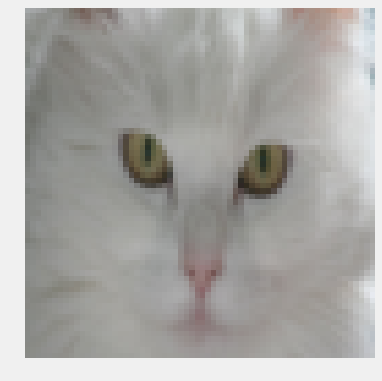

In [2]:
# Import training data
train_dataset = h5py.File("../data/train_catvnoncat.h5")
X_train = np.array(train_dataset["train_set_x"])
Y_train = np.array(train_dataset["train_set_y"])

# Plot a sample image
plt.imshow(X_train[50])
plt.axis("off");

# Import test data
test_dataset = h5py.File("../data/test_catvnoncat.h5")
X_test = np.array(test_dataset["test_set_x"])
Y_test = np.array(test_dataset["test_set_y"])

# Transform data
X_train = X_train.reshape(209, -1).T
X_train = X_train / 255
Y_train = Y_train.reshape(-1, 209)

X_test = X_test.reshape(50, -1).T
X_test = X_test / 255
Y_test = Y_test.reshape(-1, 50)

# print the new shape of both training and test datasets
print("Training data dimensions:")
print("X's dimension: {}, Y's dimension: {}".format(X_train.shape, Y_train.shape))
print("Test data dimensions:")
print("X's dimension: {}, Y's dimension: {}".format(X_test.shape, Y_test.shape))

The training set has 209 examples and the test set has 50 examples. Let's first write all the helper functions that would help us write the multi-layer neural network.

In [3]:
# Regularization (L2)
def compute_cost_reg(AL, Y, parameters, lambd=0):
    """
    Computes the Cross-Entropy cost function with L2 regularization.

    Arguments:
    AL -- post-activation, output of forward propagation, shape:
          output size x number of examples.
    Y --  labels vector, shape: output size x number of examples.
    parameters -- python dictionary containing parameters of the model.
    lambd -- regularization hyperparameter --> scalar.

    Returns:
    cost - value of the regularized loss function.
    """
    # number of examples
    m = Y.shape[1]

    # compute traditional cross entropy cost
    cross_entropy_cost = compute_cost(AL, Y)

    # convert parameters dictionary to vector
    parameters_vector = dictionary_to_vector(parameters)

    # compute the regularization penalty
    L2_regularization_penalty = (
        lambd / (2 * m)) * np.sum(np.square(parameters_vector))

    # compute the total cost
    cost = cross_entropy_cost + L2_regularization_penalty

    return cost


def linear_backword_reg(dZ, cache, lambd=0):
    """
    Computes the gradient of the output w.r.t weight, bias, and post-activation
    output of (l - 1) layers at layer l.
    
    Arguments:
    dZ -- Gradient of the cost with respect to the linear output
          (of current layer l).
    cache -- tuple of values (A_prev, W, b) coming from the forward
             propagation in the current layer.
    lambd -- regularization hyperparameter --> scalar.

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation
               (of the previous layer l-1).
    dW -- Gradient of the cost with respect to W (current layer l).
    db -- Gradient of the cost with respect to b (current layer l).
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1 / m) * np.dot(dZ, A_prev.T) + (lambd / m) * W
    db = (1 / m) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)

    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)

    return dA_prev, dW, db


def linear_activation_backward_reg(dA, cache, activation_fn="relu", lambd=0):
    """
    Arguments:
    dA -- post-activation gradient for current layer l
    cache -- tuple of values (linear_cache, activation_cache)
    activation -- the activation to be used in this layer, stored as a string:
                  "sigmoid", "tanh", or "relu"
    lambd -- regularization hyperparameter --> scalar.

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation
               (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l),
          same shape as W
    db -- Gradient of the cost with respect to b (current layer l),
          same shape as b
    """
    linear_cache, activation_cache = cache

    if activation_fn == "sigmoid":
        dZ = sigmoid_gradient(dA, activation_cache)
        dA_prev, dW, db = linear_backword_reg(dZ, linear_cache, lambd)

    elif activation_fn == "tanh":
        dZ = tanh_gradient(dA, activation_cache)
        dA_prev, dW, db = linear_backword_reg(dZ, linear_cache, lambd)

    elif activation_fn == "relu":
        dZ = relu_gradient(dA, activation_cache)
        dA_prev, dW, db = linear_backword_reg(dZ, linear_cache, lambd)

    return dA_prev, dW, db


def L_model_backward_reg(AL, Y, caches, hidden_layers_activation_fn="relu",
                         lambd=0):
    """
    Computes the gradient of output layer w.r.t weights, biases, etc. starting
    on the output layer in reverse topological order.
    
    Arguments:
    AL -- probability vector, output of the forward propagation
          (L_model_forward()).
    Y -- true vector.
    caches -- list of caches.
    hidden_layers_activation_fn -- activation function to be used on hidden
                                   layers, string: "tanh", "relu".
    lambd -- regularization hyperparameter --> scalar.

    Returns:
    grads -- A dictionary with the gradients.
    """
    Y = Y.reshape(AL.shape)
    L = len(caches)
    grads = {}

    dAL = np.divide(AL - Y, np.multiply(AL, 1 - AL))

    grads["dA" + str(L - 1)], grads["dW" + str(L)], grads["db" + str(L)] =\
        linear_activation_backward_reg(dAL, caches[L - 1], "sigmoid", lambd)

    for l in range(L - 1, 0, -1):
        current_cache = caches[l - 1]
        grads["dA" + str(l - 1)], grads["dW" + str(l)], grads["db" + str(l)] =\
            linear_activation_backward_reg(
                grads["dA" + str(l)], current_cache,
                hidden_layers_activation_fn, lambd)

    return grads


def model_with_regularization(
        X, Y, layers_dims, learning_rate=0.01, num_iterations=3000,
        print_cost=False, hidden_layers_activation_fn="relu", lambd=0,
        keep_prob=1):
    """
    Implements L-Layer neural network.

    Arguments:
    X -- input data, shape: num_px * num_px * 3 x number of examples.
    Y -- label vector, shape: 1 x number of examples.
    layers_dims -- list containing the input size and each layer size, of
                   length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule.
    num_iterations -- number of iterations of the optimization loop.
    print_cost -- if True, it prints the cost every 100 steps.
    hidden_layers_activation_fn -- activation function to be used on hidden
                                   layers, string: "tanh", "relu".
    lambd -- regularization hyperparameter --> scalar.
    keep_prob - probability of keeping a neuron active during drop-out, scalar.

    Returns:
    parameters -- parameters learnt by the model. They can then be used
                  to predict.
    """
    # get number of examples
    m = X.shape[1]

    # to get consistents output
    np.random.seed(1)

    # initialize parameters
    parameters = initialize_parameters(layers_dims)

    # intialize cost list
    cost_list = []

    # implement gradient descent
    for i in range(num_iterations):
        # compute forward propagation
        AL, caches = L_model_forward(
            X, parameters, hidden_layers_activation_fn)

        # compute regularized cost
        reg_cost = compute_cost_reg(AL, Y, parameters, lambd)

        # compute gradients
        grads = L_model_backward_reg(
            AL, Y, caches, hidden_layers_activation_fn, lambd)

        # update parameters
        parameters = update_parameters(parameters, grads, learning_rate)

        # print cost
        if (i + 1) % 100 == 0 and print_cost:
            print("The regularized cost after {} iterations: {}".format(
                (i + 1), reg_cost))

        # append cost
        if i % 100 == 0:
            cost_list.append(reg_cost)

    # plot the cost curve
    plt.plot(cost_list)
    plt.xlabel("Iterations (per hundreds)")
    plt.ylabel("Cost")
    plt.title("Cost curve for the learning rate = {}".format(learning_rate))

    return parameters

Now we're ready to train the neural network. We'll first build a neural network with no regularization and then one with regularization to see which one has lower generalization error. Note that $\lambda$ should be tuned to get the best results but we'll here choose an arbitrary value to illustrate the concept. Both neural netwotks would have 2 hidden layers where each hidden layer has 5 units.

The regularized cost after 100 iterations: 0.6555634398145331
The regularized cost after 200 iterations: 0.6467746423961933
The regularized cost after 300 iterations: 0.6446638811282552
The regularized cost after 400 iterations: 0.6441400737542232
The regularized cost after 500 iterations: 0.6440063101787575
The regularized cost after 600 iterations: 0.6439697872317176
The regularized cost after 700 iterations: 0.6439570623358253
The regularized cost after 800 iterations: 0.6439491872993496
The regularized cost after 900 iterations: 0.6439407592837082
The regularized cost after 1000 iterations: 0.6439294591543208
The regularized cost after 1100 iterations: 0.6439131091764411
The regularized cost after 1200 iterations: 0.6438883396380859
The regularized cost after 1300 iterations: 0.6438489715870495
The regularized cost after 1400 iterations: 0.6437825798034876
The regularized cost after 1500 iterations: 0.6436617691190204
The regularized cost after 1600 iterations: 0.6434191397054715
T

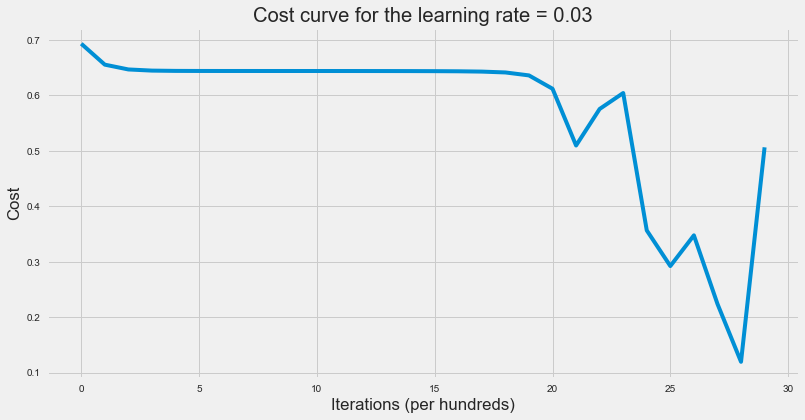

In [4]:
# set up layers dimensions
layers_dims = [X_train.shape[0], 5, 5, 1]

# train NN
parameters = model_with_regularization(X_train, Y_train, layers_dims,
                                       learning_rate=0.03, print_cost=True,
                                       hidden_layers_activation_fn="tanh",
                                       lambd=0)

# print the test accuracy
print("The training accuracy rate: {}".format(accuracy(X_train, parameters, Y_train, "tanh")[-7:]))
print("The test accuracy rate: {}".format(accuracy(X_test, parameters, Y_test, "tanh")[-7:]))

The training accuracy is 93.78% but the test accuracy is 70%. Therefore, it's obvious that we have an overfitting issue. Let's use L2 parameter regularization to improve the generalization error. Values of $\lambda$s that practitioners recommend are: 0.02, 0.04, 0.08, 0.16, 0.32, 0.64, 1.28, 2.56, 5.12, 10.24. We'll use here $\lambda = 0.08$.

The regularized cost after 100 iterations: 0.6567614925220248
The regularized cost after 200 iterations: 0.6479948749224337
The regularized cost after 300 iterations: 0.6458971980656789
The regularized cost after 400 iterations: 0.6453794752422721
The regularized cost after 500 iterations: 0.6452477263525883
The regularized cost after 600 iterations: 0.6452110629493458
The regularized cost after 700 iterations: 0.6451971297631234
The regularized cost after 800 iterations: 0.6451875828145244
The regularized cost after 900 iterations: 0.6451773802643587
The regularized cost after 1000 iterations: 0.6451644728073699
The regularized cost after 1100 iterations: 0.6451469767044827
The regularized cost after 1200 iterations: 0.6451219780216011
The regularized cost after 1300 iterations: 0.6450841750752557
The regularized cost after 1400 iterations: 0.6450230711784416
The regularized cost after 1500 iterations: 0.6449160083502017
The regularized cost after 1600 iterations: 0.6447087277940003
T

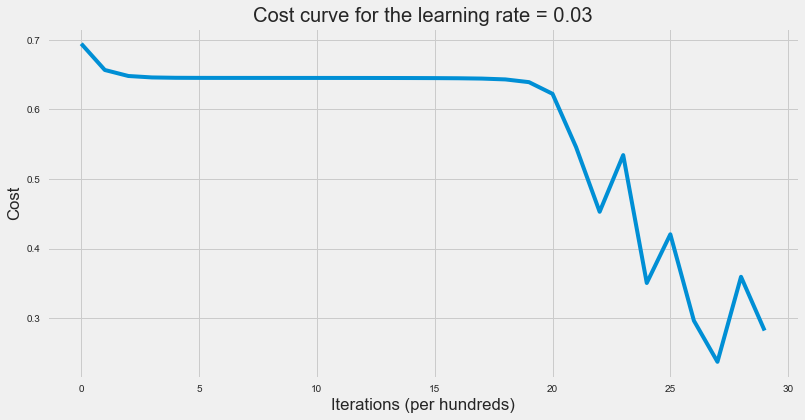

In [5]:
# train NN with regularization
parameters = model_with_regularization(X_train, Y_train, layers_dims,
                                       learning_rate=0.03, print_cost=True,
                                       hidden_layers_activation_fn="tanh",
                                       lambd=0.08)

# print the test accuracy
print("The training accuracy rate: {}".format(accuracy(X_train, parameters, Y_train, "tanh")[-7:]))
print("The test accuracy rate: {}".format(accuracy(X_test, parameters, Y_test, "tanh")[-7:]))

As the results above shows, we improved the generalization error by increasing the test accuracy from 70% to 78%. On the other hand, training accuracy decreased from 93.78% to 88.52%.

<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Conclusion
</h2>

Regularization is an effective technique to resolve overfitting. Since we don't know true distribution of the data, empirical risk which is based of empirical distribution is prone to overfitting. Therefore, the best strategy is to fit training data really well and then use a regularization technique so that the model generalizes well. L2 parameter regularization is one of the most widely used regularization technique in machine learning.
- One of the implicit assumptions of regularization techniques such as L2 and L1 parameter regularization is that the value of the parameters should be zero and try to shrink all parameters towards zero. It's meant to avoid following the training data very well which makes the learning algorithm picks some noise that is not helpful when applied on unseen data.
- The value of $\lambda$ should be tuned to get the best generalization error. We typically use validation set when comparing models with values for $\lambda$s and pick the one with the lowest validation error.
- Only use regularization if the model suffers from overfitting, i.e training error << validation error.
- If the after using regularization the validation error is still high, then we're most like in the underfitting region. In other words, our model is still too simple and already has high bias. Therefore, add complexity to the model and then use regularization.